# Image analysis



In [1]:

import numpy as np
from scipy.ndimage import gaussian_filter
from spectrum.correlation import xcorr


import pandas as pd

import matplotlib.pyplot as plt

import os

from tifffile import TiffFile
import ipywidgets as widgets
from IPython.display import display, clear_output

import steerable

from skimage.morphology import disk, white_tophat
from skimage.transform import resize


## Detect nematic order
### Parameter
test

In [2]:
# Background subtraction
GBlur_Sigma = 2 

# ROIsMask (obtained from Mask)
ROI_Size = 30 # [pixels] 

# Tophat filtering
Tophat_Sigma = 28 

# Steerable Filter
Steerable_Sigma = 2 # Size for Steerable filter  

# Mask treshold to filter interesting structures for ROI 
Mask_Thresh =350 # it varies for different time points of myofibrillogenesis

# ROIsMask (obtained from Mask)
ROI_Thresh = 0.3 # minimal value used, some stages increase up to 0.85

# Padding
Pad_Angle = 6 # Window size --> we will crop image to ensure linescans are not reaching edge of image
Pad_Corr = 3 # [pixel]
ROI_Pad_Corr = (ROI_Size+(ROI_Size*(Pad_Corr-1))*2)

### Image read in

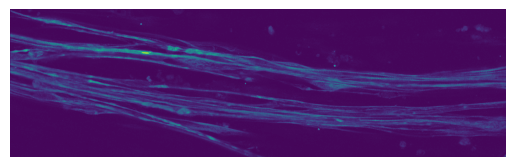

(1946, 6540)

In [3]:
# Define the file path
input_figures_directory = 'Data/'
fly1_image_name = '2023.06.12_MhcGFPweeP26_24hrsAPF_Phallo568_647nano62actn_405nano2sls_100Xz2.5_1_2.tif'
fly2_image_name = '2023.06.12_MhcGFPweeP26_30hrsAPF_Phallo568_647nano62actn_405nano2sls_100Xz2.5_1_2.tif'
human_image_name = 'Trial8_D12_488-TTNrb+633-MHCall_DAPI+568-Rhod_100X_01_stitched.tif'
image_filename = fly1_image_name

raw_path = os.path.join(input_figures_directory, image_filename)

# Open the image
tif = TiffFile(raw_path)
plt.imshow(tif.pages[0].asarray())
plt.axis('off')
plt.show()
len(tif.pages)

tif.pages[0].asarray().shape

Number of slices: 1.0
Number of channels: 4
Pixel size: 0.033210633327441764 µm
Image size: 1000 x 1000 pixels


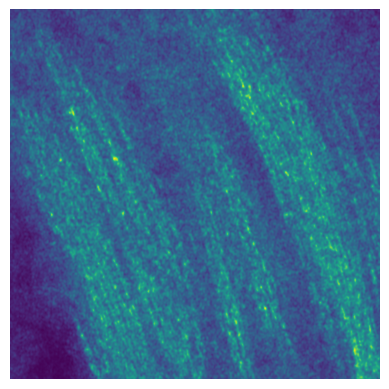

IntSlider(value=0, description='channel index', max=3)

In [19]:
# Define the file path
input_figures_directory = 'Data/'
fly1_image_name = '2023.06.12_MhcGFPweeP26_24hrsAPF_Phallo568_647nano62actn_405nano2sls_100Xz2.5_1_2.tif'
fly2_image_name = '2023.06.12_MhcGFPweeP26_30hrsAPF_Phallo568_647nano62actn_405nano2sls_100Xz2.5_1_2.tif'
human_image_name = 'Trial8_D12_488-TTNrb+633-MHCall_DAPI+568-Rhod_100X_01_stitched.tif'
image_filename = fly1_image_name

raw_path = os.path.join(input_figures_directory, image_filename)

# Open the image
tif = TiffFile(raw_path)

# Get the number of frames
n = len(tif.pages)
num_channels = 4
num_slices = n/num_channels

# Create slider for frame selection
if num_slices >1:
    slice_widget = widgets.IntSlider(min=0, max=num_slices-1, step=1, value=0, description='slice index')
channel_widget = widgets.IntSlider(min=0, max=num_channels-1, step=1, value=0, description='channel index')

# Define the function to display the selected frame
def display_frame(channel_index, slice_index=0):
    clear_output(wait=True)
    # Select the frame
    raw = np.asarray(tif.pages[channel_index+slice_index].asarray())

    # Get the metadata
    info = tif.pages[channel_index+slice_index].tags
    
    # Get the image factor
    factor = info['XResolution'].value[0]  # The XResolution tag is a ratio, so we take the numerator
    pixSize = 1 / factor *10**(6)  # Factor to go from pixels to micrometers

    # Get Image size
    nY, nX = raw.shape

    print('Number of slices: ' + str(num_slices))
    print('Number of channels: ' + str(num_channels))
    print('Pixel size: ' + str(pixSize) + ' µm')
    print('Image size: ' + str(nX) + ' x ' + str(nY) + ' pixels')
    

    # Display the image
    fig, ax = plt.subplots()
    ax.imshow(raw)
    ax.axis('off')  # Remove axis
    plt.show()
    
    # Display the widget
    display(channel_widget)
    if 'slice_widget' in locals():
        display(slice_widget)

# Call the function to display the initial frame
if 'slice_widget' in locals():
    display_frame(channel_widget.value,slice_widget.value)
else:
    display_frame(channel_widget.value)

# Define the function to update the displayed frame
def update_channel(change):
    display_frame(change.new, slice_widget.value if 'slice_widget' in locals() else 0)

def update_slice(change):
    display_frame(channel_widget.value, change.new)

# Connect the widget to the update function
channel_widget.observe(update_channel, 'value')
if 'slice_widget' in locals():
    slice_widget.observe(update_slice, 'value')

### Select a slice and channel for mask
Fly:
- frame 0: alpha-actinin
- frame 1: actin
- frame 2: myosin
- frame 3: sallimus (MASK CHANNEL)

Human cell:
- frame 0: titin N-terminus (MASK CHANNEL)
- frame 1: muscle myosin
- frame 2: nuclei 
- frame 3: actin


In [29]:
# Get the slice and channel for mask
slice_index = 0
channel_index = 3
raw = np.asarray(tif.pages[4*slice_index+channel_index].asarray())
info = tif.pages[4*slice_index+channel_index].tags
# Get variables
nY, nX = raw.shape
qLow = np.quantile(raw, 0.001)
qHigh = np.quantile(raw, 0.999)

# get image factor
factor = info['XResolution'].value[0]  # The XResolution tag is a ratio, so we take the numerator
pixSize = 1 / factor *10**(6) # Factor to go from pixels to micrometers


### Mask and background substraction
interactive widget to choose parameters

In [30]:

# Sliders
mask_thresh_slider = widgets.IntSlider(min=0, max=500, step=50, value=Mask_Thresh, description='Mask_Thresh')
roi_thresh_slider = widgets.FloatSlider(min=0, max=0.85, step=0.1, value=ROI_Thresh, description='ROI_Thresh')
roi_size_slider = widgets.IntSlider(min=0, max=100, step=5, value=ROI_Size, description='ROI_Size')
gblur_sigma_slider = widgets.FloatSlider(min=0, max=4, step=0.5, value=GBlur_Sigma, description='GBlur_Sigma')
def display_frame(mask_thresh,roi_thresh, roi_size, gblur_sigma):
    clear_output(wait=True)

    # Crop raw image
    nGridY = int(np.floor(nY / roi_size))
    nGridX = int(np.floor(nX / roi_size))
    raw_crop = raw[:nGridY * roi_size, :nGridX * roi_size]
    nYCrop, nXCrop = raw_crop.shape

    # Subtract background
    raw_bgsub = gaussian_filter(raw_crop, sigma=gblur_sigma)  # Gaussian blur

    # Create Mask
    # Binary mask; I<Threshold --> Black, I>Threshold --> White
    raw_mask = raw_bgsub.copy()
    raw_mask[raw_mask < mask_thresh] = 0
    raw_mask[raw_mask >= mask_thresh] = 1

    # Create ROIsMask
    raw_rois_mask = np.zeros((nGridY, nGridX))
    white_percentage = np.zeros((nGridY, nGridX))
    for i in range(nGridY):
        for j in range(nGridX):
            temp = raw_mask[i*roi_size:(i+1)*roi_size, j*roi_size:(j+1)*roi_size].mean()
            white_percentage[i, j] = temp  # how many pixels per ROI are white
            if temp > roi_thresh:
                if i >= Pad_Angle - 1 and i <= nGridY - Pad_Angle and j >= Pad_Angle - 1 and j <= nGridX - Pad_Angle:
                    raw_rois_mask[i, j] = 1

    # Display
    #plt.figure(figsize=(5, 5))

    # Mask
    plt.subplot(1, 2, 1)
    plt.imshow(raw_mask, cmap='gray')
    plt.title(f'Mask')

    # ROIsMask
    plt.subplot(1, 2, 2)
    plt.imshow(raw_rois_mask, cmap='gray')
    plt.title(f'ROIsMask')
    plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.1, hspace=0.5)
    

# Display sliders
widgets.interact(display_frame, mask_thresh=mask_thresh_slider, roi_thresh=roi_thresh_slider, roi_size=roi_size_slider, gblur_sigma=gblur_sigma_slider)



interactive(children=(IntSlider(value=350, description='Mask_Thresh', max=500, step=50), FloatSlider(value=0.3…

<function __main__.display_frame(mask_thresh, roi_thresh, roi_size, gblur_sigma)>

#### change parameter if need be

In [31]:
# Background subtraction
GBlur_Sigma = 2 

# ROIsMask (obtained from Mask)
ROI_Size = 30 # [pixels] 

# Tophat filtering
Tophat_Sigma = 28 

# Steerable Filter
Steerable_Sigma = 2 # Size for Steerable filter  

# Mask treshold to filter interesting structures for ROI 
Mask_Thresh =350 # it varies for different time points of myofibrillogenesis

# ROIsMask (obtained from Mask)
ROI_Thresh = 0.3 # minimal value used, some stages increase up to 0.85

# Padding
Pad_Angle = 6 # Window size --> we will crop image to ensure linescans are not reaching edge of image
Pad_Corr = 3 # [pixel]
ROI_Pad_Corr = (ROI_Size+(ROI_Size*(Pad_Corr-1))*2)

#### Mask and ROI Mask with those parameters

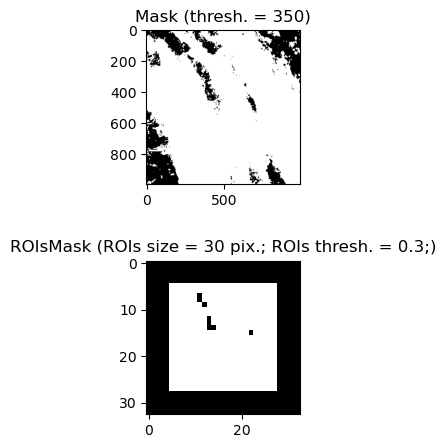

<Figure size 500x500 with 0 Axes>

In [32]:


# Crop raw image
nGridY = int(np.floor(nY / ROI_Size))
nGridX = int(np.floor(nX / ROI_Size))

# TODO: check if this is correct
raw = raw[:nGridY * ROI_Size, :nGridX * ROI_Size]
nYCrop, nXCrop = raw.shape


# Subtract background
Raw_BGSub = gaussian_filter(raw, sigma=GBlur_Sigma)  # Gaussian blur #2

# Create Mask
# Binary mask; I<Threshold --> Black, I>Threshold --> White
Raw_Mask = Raw_BGSub.copy()

Raw_Mask[Raw_Mask < Mask_Thresh] = 0
Raw_Mask[Raw_Mask >= Mask_Thresh] = 1

# Create ROIsMask
Raw_ROIsMask = np.zeros((nGridY, nGridX))
white_percentage = np.zeros((nGridY, nGridX))
for i in range(nGridY):
    for j in range(nGridX):
        temp = Raw_Mask[i*ROI_Size:(i+1)*ROI_Size, j*ROI_Size:(j+1)*ROI_Size].mean()
        white_percentage[i, j] = temp  # how many pixels per ROI are white
        if temp > ROI_Thresh:
            if i >= Pad_Angle and i <= nGridY - Pad_Angle and j >= Pad_Angle and j <= nGridX - Pad_Angle:
                Raw_ROIsMask[i, j] = 1

# Crop raw image
nGridY = int(np.floor(nY / ROI_Size))
nGridX = int(np.floor(nX / ROI_Size))

# TODO: check if this is correct
raw = raw[:nGridY * ROI_Size, :nGridX * ROI_Size]
nYCrop, nXCrop = raw.shape


# Subtract background
Raw_BGSub = gaussian_filter(raw, sigma=GBlur_Sigma)  # Gaussian blur #2

# Create Mask
# Binary mask; I<Threshold --> Black, I>Threshold --> White
Raw_Mask = Raw_BGSub.copy()

Raw_Mask[Raw_Mask < Mask_Thresh] = 0
Raw_Mask[Raw_Mask >= Mask_Thresh] = 1

# Create ROIsMask
Raw_ROIsMask = np.zeros((nGridY, nGridX))
white_percentage = np.zeros((nGridY, nGridX))
for i in range(nGridY):
    for j in range(nGridX):
        temp = Raw_Mask[i*ROI_Size:(i+1)*ROI_Size, j*ROI_Size:(j+1)*ROI_Size].mean()
        white_percentage[i, j] = temp  # how many pixels per ROI are white
        if temp > ROI_Thresh:
            if i >= Pad_Angle - 1 and i <= nGridY - Pad_Angle and j >= Pad_Angle - 1 and j <= nGridX - Pad_Angle:
                Raw_ROIsMask[i, j] = 1
np.savetxt("comparison/Raw_BGSub.csv", Raw_BGSub, delimiter=",", fmt='%f')
np.savetxt("comparison/Raw_Mask.csv", Raw_Mask, delimiter=",", fmt='%f')
np.savetxt("comparison/Raw_ROIsMask.csv", Raw_ROIsMask, delimiter=",", fmt='%f')
# Display

# Mask
plt.subplot(2, 1, 1)
plt.imshow(Raw_Mask, cmap='gray')
plt.title(f'Mask (thresh. = {Mask_Thresh})')

# ROIsMask
plt.subplot(2, 1, 2)
plt.imshow(Raw_ROIsMask, cmap='gray')
plt.title(f'ROIsMask (ROIs size = {ROI_Size} pix.; ROIs thresh. = {ROI_Thresh};)')

plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.1, hspace=0.5)
plt.figure(figsize=(5, 5))
plt.show()

interactive widget to choose 'steerable Sigma'

In [33]:
# Create a disk-shaped structuring element
selem = disk(Tophat_Sigma)

# Perform the top-hat transformation
Raw_Tophat = white_tophat(Raw_BGSub, selem)


# slider for steerable filter variable
steerable_sigma_slider = widgets.IntSlider(min=0, max=4, step=0.5, value=Steerable_Sigma, description='Steerable_Sigma')

# Steerable Filter
RawRSize = resize(raw, (nGridY, nGridX), order=0)  # nearest-neighbor interpolation
MaskRSize = resize(Raw_Mask, (nGridY, nGridX), order=0)  # nearest-neighbor interpolation   
# Convert the image to 'double'
RawRSize = RawRSize.astype(np.float64)

def display_frame(steerable_sigma):
    clear_output(wait=True)
    sd = steerable.Detector2D(RawRSize, 2, steerable_sigma)
    res, _ = sd.filter()
    rot = np.transpose(sd.get_angle_response(180))
    for i in range(rot.shape[2]):
        temp = rot[:, :, i]
        temp[MaskRSize == 0] = np.nan
        rot[:, :, i] = temp

    # Make AngleMap
    AngleMap = np.zeros((nGridY, nGridX))
    for i in range(nGridY):
        for j in range(nGridX):
            if Raw_ROIsMask[i, j] == 1:
                Crop = rot[i-(Pad_Angle-1):i+(Pad_Angle), j-(Pad_Angle-1):j+(Pad_Angle), :]
                idxMax = np.full(Crop.shape[2], np.nan)
                for k in range(Crop.shape[2]):
                    temp = Crop[:, :, k]
                    idxMax[k] = np.nanmean(temp)
                M, I = np.nanmax(idxMax), np.nanargmax(idxMax)
                AngleMap[i, j] = I+1
    # Display
    plt.figure(figsize=(10, 10))
    plt.subplot(3, 1, 1)
    plt.imshow(raw, cmap='gray', vmin=qLow, vmax=qHigh)
    plt.title('Raw')

    plt.subplot(3, 1, 2)
    plt.imshow(res, cmap='gray', vmin=np.min(res), vmax=np.max(res))
    plt.title(f'Steerable filter (sigma = {Steerable_Sigma} pix.)')

    Raw_new = np.ones((raw.shape[0], raw.shape[1]))
    plt.subplot(3, 1, 3)
    plt.imshow(Raw_new, cmap='gray', vmin=qLow, vmax=qHigh)
    for i in range(nGridY):
        for j in range(nGridX):
            if Raw_ROIsMask[i, j] == 1:
                Angle = AngleMap[i, j]
                k = 0
                xi = ROI_Size*(j+1) + ROI_Size * np.array([-1, 1]) * np.cos((90-Angle)*-1*np.pi/180) + k*np.cos(Angle*np.pi/180)
                yi = ROI_Size*(i+1) + ROI_Size * np.array([-1, 1]) * np.sin((90-Angle)*-1*np.pi/180) + k*np.sin(Angle*np.pi/180)
                plt.plot(xi, yi, 'c')
    plt.tight_layout()
    plt.show()

# Display sliders
widgets.interact(display_frame, steerable_sigma=steerable_sigma_slider)
    

interactive(children=(IntSlider(value=2, description='Steerable_Sigma', max=4, step=0), Output()), _dom_classe…

<function __main__.display_frame(steerable_sigma)>

In [26]:
#change steerable sigma if needed
Steerable_Sigma = 2


(180, 218, 64)
(64, 218, 180)


/tmp/ipykernel_72981/2600018933.py:85: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  tmp_1 = pd.concat([tmp_1, pd.DataFrame({'x1':[xi[0]], 'y1':[yi[0]], 'x2':[xi[1]], 'y2':[yi[1]]})], ignore_index=True)


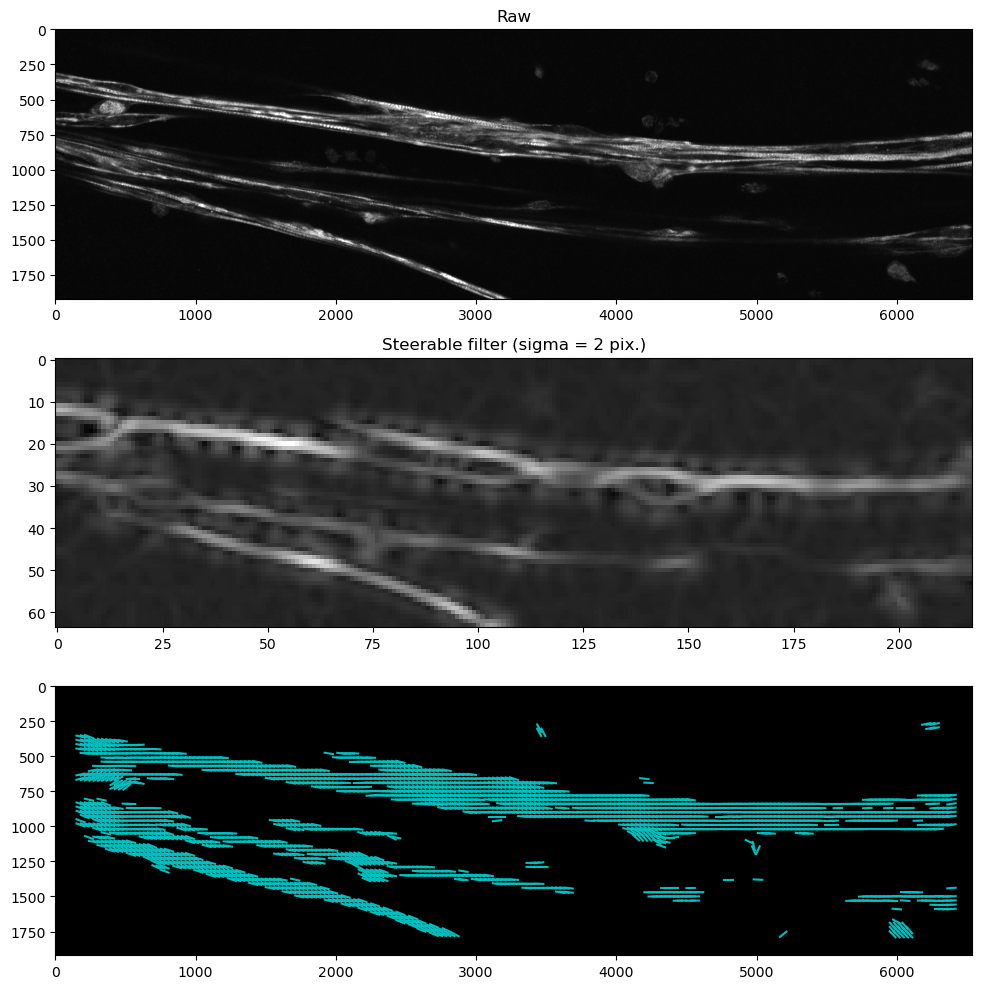

In [18]:
import imageio
import matplotlib.style as style
style.use('default')

# Top Hat Transformation
#Raw_Tophat = white_tophat(Raw_BGSub, selem=disk(Tophat_Sigma))

# Create a disk-shaped structuring element
selem = disk(Tophat_Sigma)

# Perform the top-hat transformation
Raw_Tophat = Raw_BGSub#white_tophat(Raw_BGSub, selem)
#np.savetxt("comparison/Raw_Tophat.csv", Raw_Tophat, delimiter=",", fmt='%f')

# Measure Local Nematic Order

# Steerable Filter
RawRSize = resize(raw, (nGridY, nGridX), order=0)  # nearest-neighbor interpolation
MaskRSize = resize(Raw_Mask, (nGridY, nGridX), order=0)  # nearest-neighbor interpolation   
# Load the PNG images
RawRSize = RawRSize.astype(np.float64)
# Implement steerableDetector function
sd = steerable.Detector2D(RawRSize, 2, Steerable_Sigma)
res, _ = sd.filter()
rot = np.asarray(sd.get_angle_response(180))
print(rot.shape)
rot = np.transpose(rot)
print(rot.shape)
np.savetxt("comparison/rot_1.csv", rot[:,:,0], delimiter=",", fmt='%f')
np.savetxt("comparison/res_1.csv", res, delimiter=",", fmt='%f')
for i in range(rot.shape[2]):
    temp = rot[:, :, i]
    temp[MaskRSize == 0] = np.nan
    rot[:, :, i] = temp

# Make AngleMap
AngleMap = np.zeros((nGridY, nGridX))
for i in range(nGridY):
    for j in range(nGridX):
        if Raw_ROIsMask[i, j] == 1:
            x_idx = [i-(Pad_Angle-1),i+(Pad_Angle)]
            y_idx =  [j-(Pad_Angle-1),j+(Pad_Angle)]
            Crop = rot[x_idx[0]:x_idx[1],y_idx[0]:y_idx[1],  :]
            idxMax = np.full(Crop.shape[2], np.nan)
            for k in range(Crop.shape[2]):
                temp = Crop[:, :, k]
                if not np.all(np.isnan(temp)):  # Check if all values are NaN
                    idxMax[k] = np.nanmean(temp)
            if not np.all(np.isnan(idxMax)):  # Check if all values are NaN
                M, I = np.nanmax(idxMax), np.nanargmax(idxMax)
                AngleMap[i, j] = I+1
            
# save anglemap as csv
np.savetxt("comparison/AngleMap_1.csv", AngleMap, delimiter=",", fmt='%f')
# Display
plt.figure(figsize=(10, 10))
plt.subplot(3, 1, 1)
plt.imshow(raw, cmap='gray', vmin=qLow, vmax=qHigh)
plt.title('Raw')

plt.subplot(3, 1, 2)
plt.imshow(res, cmap='gray', vmin=np.min(res), vmax=np.max(res))
plt.title(f'Steerable filter (sigma = {Steerable_Sigma} pix.)')
np.savetxt("comparison/Res_1.csv", res, delimiter=",", fmt='%f')


Raw_new = np.ones((raw.shape[0], raw.shape[1]))
plt.subplot(3, 1, 3)
plt.imshow(Raw_new, cmap='gray', vmin=qLow, vmax=qHigh)

#fig, ax = plt.subplots()  # Create a new figure with a subplot
#plt.imshow(Raw_new, cmap='gray', vmin=qLow, vmax=qHigh)

# Initialize an empty DataFrame to store xi and yi values
tmp_1 = pd.DataFrame(columns=['x1', 'x2', 'y1', 'y2'])
for i in range(nGridY):
    for j in range(nGridX):
        if Raw_ROIsMask[i, j] == 1:
            Angle = AngleMap[i, j]
            k = 0
            xi = ROI_Size*(j+1) + ROI_Size * np.array([-1, 1]) * np.cos((90-Angle)*-1*np.pi/180) + k*np.cos(Angle*np.pi/180)
            yi = ROI_Size*(i+1) + ROI_Size * np.array([-1, 1]) * np.sin((90-Angle)*-1*np.pi/180) + k*np.sin(Angle*np.pi/180)
            plt.plot(xi, yi, 'c')
            # Append xi and yi values to the DataFrame
            tmp_1 = pd.concat([tmp_1, pd.DataFrame({'x1':[xi[0]], 'y1':[yi[0]], 'x2':[xi[1]], 'y2':[yi[1]]})], ignore_index=True)

# Save the DataFrame to a CSV file
tmp_1.to_csv('comparison/xi_yi_values_1.csv', index=False)

# Save the subplot as a high-resolution PDF
#fig.savefig('comparison/subplot.pdf', format='pdf', dpi=300)

plt.tight_layout()
plt.show()



# Save all parameters needed for next script
#Parameters = np.array([GBlur_Sigma, Mask_Thresh, ROI_Size, ROI_Thresh, Tophat_Sigma, Steerable_Sigma])
#Parameters = pd.DataFrame(Parameters, index=['GBlur_Sigma', 'Mask_Thresh', 'ROI_Size', 'ROI_Thresh', 'Tophat_Sigma', 'Steerable_Sigma'])

In [31]:
# save res as csv
np.max(res)

114.55949309151457

## Correlation function

In [32]:
def intensity_profile(image, start, end, num_points):
    """
    Calculate the intensity profile along a line segment in an image.

    Parameters:
        image : The input image (grayscale).
        start (tuple): The starting point of the line segment (x, y).
        end (tuple): The ending point of the line segment (x, y).
        num_points (int): The number of equally spaced points to sample along the line segment.

    Returns:
        numpy.ndarray: The intensity profile along the line segment, normalized between 0 and 1.
    """

    # convert image numpy array
    image_data = np.array(image)
    nrows, ncols = image_data.shape[0], image_data.shape[1]

    # check if start and end points are within image
    if start[0] < 0 or start[0] > ncols or start[1] < 0 or start[1] > nrows:
        raise ValueError('start point is not within image')
    if end[0] < 0 or end[0] > ncols or end[1] < 0 or end[1] > nrows:
        raise ValueError('end point is not within image')

    if end[0] != start[0]:
        # calculate slope and y-intercept
        slope = (end[1] - start[1]) / (end[0] - start[0])
        y_intercept = start[1] - slope * start[0]
        def line(x):
            return slope * x + y_intercept

        # calculate num_points equally spaced integer (x,y) coordinates along the line
        x = np.linspace(start[0], end[0], num_points, dtype=int)
        y = np.round(line(x)).astype(int)
    else:
        y = np.linspace(start[1], end[1], num_points, dtype=int)
        x = np.full(num_points, start[0], dtype=int)

    # read out image values at the coordinates
    values = image_data[y, x]

    # get intensity values between 0 and 1
    min_value, max_value = values.min(), values.max()
    diff = max_value - min_value
    intensity = (values - min_value) / diff
    return intensity

In [38]:
nGridX

33

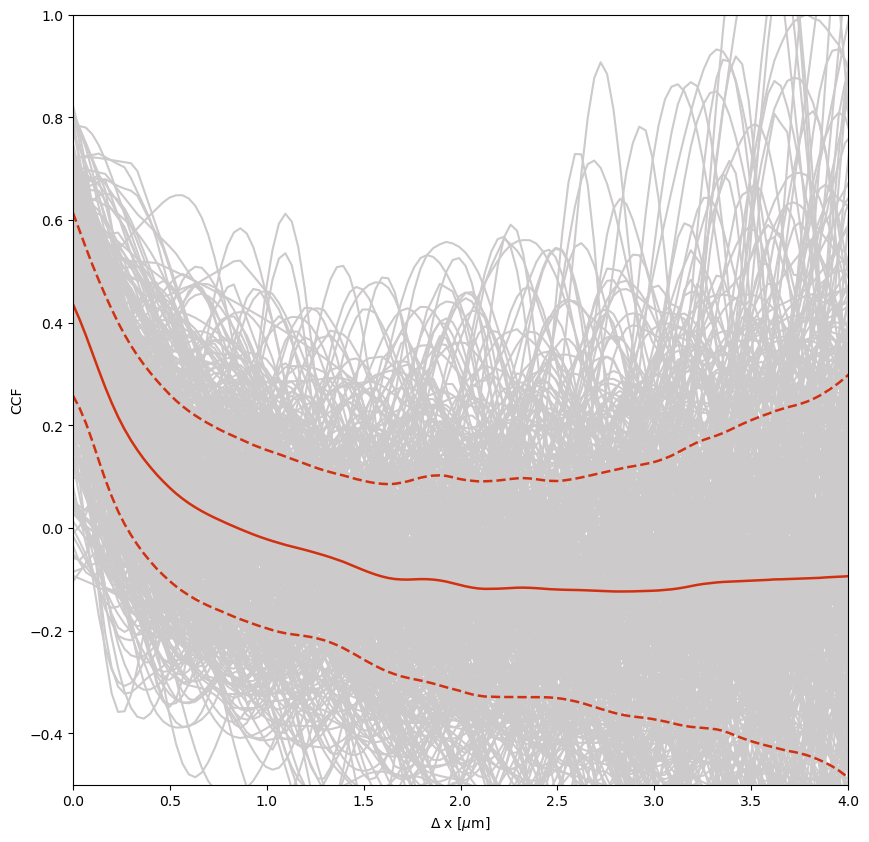

In [35]:
from skimage.io import imsave

# Choose the channels
channel1 = 0  # channel for first substrate
channel2 = 3  # channel for second substrate

# get images
raw1 = raw = np.asarray(tif.pages[slice_index+channel1].asarray())

raw2 = raw = np.asarray(tif.pages[slice_index+channel2].asarray())


# apply masks
raw1_BGSub = gaussian_filter(raw1, sigma=GBlur_Sigma)
selem1 = disk(Tophat_Sigma)
raw1_Tophat = white_tophat(raw1_BGSub, selem1)
# plot raw1_Tophat
#plt.imshow(raw1_Tophat)
#plt.show()

raw2_BGSub = gaussian_filter(raw, sigma=GBlur_Sigma)
selem2 = disk(Tophat_Sigma)
raw2_Tophat = white_tophat(raw2_BGSub, selem2)

# save image raw2_Tophat as .tif
# Save image as .tif
#imsave('raw2_Tophat.tif', raw2_Tophat)
#imsave('raw1_Tophat.tif', raw1_Tophat)
# if I use the matlab script on these two images with the angles from pythono the right ccf image is created



# Define constants and parameters
corr_length = 4  # [μm]
crop_length = round(corr_length / (2 * pixSize))  # [pixel]
max_dist = round(crop_length) + 10  # +10 pixels to corr_length to smaller deviations
maxlag = 2 * max_dist  # Correlation length will be doubled because of mirror symmetry

ccf_all = np.full((nGridY * nGridX, 2 * maxlag + 1), np.nan)  # Allocate memory for ACF/CCF
MergedData = np.empty((nGridY, nGridX), dtype=object)
z = 1  # Counting number

fig, ax = plt.subplots(figsize=(10, 10))
# Computation over the whole grid
for i in range(nGridY):
    for j in range(nGridX):
        if Raw_ROIsMask[i, j] == 1:
            Angle = AngleMap[i, j]
            ccf = np.zeros(2*maxlag+1)
            var1 = 0
            var2 = 0
            kmax = 10

            for k in range(-kmax, kmax+1, 2):
                dir = np.array([-1, 1])
                xi = ROI_Size*(j+1) + max_dist*dir*np.cos((90-Angle)*-1*np.pi/180) + k*np.cos(Angle*np.pi/180)
                yi = ROI_Size*(i+1) + max_dist*dir*np.sin((90-Angle)*-1*np.pi/180) + k*np.sin(Angle*np.pi/180) # pretty much the same as in matlab (see comp.ipynb)
                start = (xi[0], yi[0])
                end = (xi[1], yi[1])
                linescan1 = intensity_profile(raw1_Tophat, start,end, 2*max_dist+1)
                linescan2 = intensity_profile(raw2_Tophat, start,end, 2*max_dist+1)
                if len(linescan1) > 2*max_dist+1:
                    linescan1 = linescan1[:2*max_dist+1]
                    linescan2 = linescan2[:2*max_dist+1]
                    
                linescan1_mean = np.mean(linescan1)
                linescan1 -= linescan1_mean
                linescan2_mean = np.mean(linescan2)
                linescan2 -= linescan2_mean
                
                cc, lag = xcorr(linescan1, linescan2, norm='unbiased') # does the same as xcorr in matlab
                cc = np.array(cc)/ (2*kmax+1)

                ccf += cc
                var1 += np.var(linescan1) / (2*kmax+1)
                var2 += np.var(linescan2) / (2*kmax+1)

            ccf /= np.sqrt(var1 * var2)
            ccf_all[i*nGridX+j, :] = ccf

            maxlag_plot = len(linescan1) - 1
            lags = np.arange(-maxlag, maxlag+1) * pixSize
            ind = np.arange(maxlag_plot, min(2*maxlag_plot+1, len(ccf), len(lags)))
            ax.plot(lags[ind], ccf[ind], color='#cccaca')
ax.set_xlabel(r'$\Delta$ x [$\mu$m]')
ax.set_xlim(0,corr_length)
ax.set_ylim(-0.5,1)
ax.set_ylabel('CCF')


# Find the valid CCFs/ACFs and calculate the mean
ccf_all_valid = ccf_all[~np.isnan(ccf_all).any(axis=1)]
mean_ccf = np.mean(ccf_all_valid, axis=0)
std_mean_ccf = np.std(ccf_all_valid, axis=0, ddof=1)

ax.plot(lags[ind], mean_ccf[ind], '-', color='#d13111', linewidth=1.8)
ax.plot(lags[ind], mean_ccf[ind] - std_mean_ccf[ind], '--', color='#d13111', linewidth=1.8)
ax.plot(lags[ind], mean_ccf[ind] + std_mean_ccf[ind], '--', color='#d13111', linewidth=1.8)

plt.show()



In [34]:
res

array([[ 12.4267591 ,  11.35025962,   7.70627152, ...,  -3.95878664,
         -2.23902731,  -1.14120719],
       [  9.61027645,   9.60387418,   7.65501866, ...,  -4.08973857,
         -2.67502601,  -1.71979876],
       [  2.11926399,   7.14588794,   9.47335672, ...,  -3.07862455,
         -2.34048897,  -2.13268957],
       ...,
       [  4.59634178,   2.24558326,   1.60493714, ...,  37.02410766,
         84.06346636, 104.0034317 ],
       [  4.70532125,   2.89472982,   3.41424879, ...,  34.63148271,
         88.61672276, 112.23484941],
       [  4.40535212,   3.03793785,   4.13788913, ...,  33.279651  ,
         89.66145342, 114.55949309]])

In [3]:
test = pd.read_csv('comparison/RawRSize.csv', header=None).to_numpy()
test = test[:,:68]
test = np.ascontiguousarray(test.astype(np.float64))
sd = steerable.Detector2D(test, 2, 2)
res, _ = sd.filter()
rot = sd.get_angle_response(180)
res

array([[ 0.48625546,  0.2298653 ,  0.01426895, ...,  0.34922395,
         0.39218542,  0.45334595],
       [ 0.45812928,  0.45754804,  1.00175702, ...,  0.82128436,
         0.83188602,  1.09516655],
       [ 1.13695407,  1.0465159 ,  0.73024233, ...,  1.26317818,
         1.18326304,  0.82002783],
       ...,
       [ 0.52779018,  0.50176045,  0.94024629, ...,  0.50349595,
         1.17817923,  1.53750926],
       [ 1.15082143,  0.65631849,  0.76510584, ...,  0.6145885 ,
         0.12901619, -0.11175457],
       [-0.3032951 ,  0.44359879,  2.4450042 , ...,  0.64779812,
         2.8856481 ,  3.9161959 ]])